# How Does DGL Represent A Graph?

https://docs.dgl.ai/tutorials/blitz/2_dglgraph.html

In [1]:
import os

os.environ["DGLBACKEND"] = "pytorch"

In [2]:
import dgl
import numpy as np
import torch

g = dgl.graph(([0, 0, 0, 0, 0], [1, 2, 3, 4, 5]), num_nodes=6)
# Equivalently, PyTorch LongTensors also work.
g = dgl.graph(
    (torch.LongTensor([0, 0, 0, 0, 0]), torch.LongTensor([1, 2, 3, 4, 5])),
    num_nodes=6,
)

# You can omit the number of nodes argument if you can tell the number of nodes from the edge list alone.
g = dgl.graph(([0, 0, 0, 0, 0], [1, 2, 3, 4, 5]))
g

Graph(num_nodes=6, num_edges=5,
      ndata_schemes={}
      edata_schemes={})

In [3]:
g.edges()

(tensor([0, 0, 0, 0, 0]), tensor([1, 2, 3, 4, 5]))

In [4]:
dgl.add_reverse_edges(g).edges()

(tensor([0, 0, 0, 0, 0, 1, 2, 3, 4, 5]),
 tensor([1, 2, 3, 4, 5, 0, 0, 0, 0, 0]))

## Assigning Node and Edge Features to Graph


In [9]:
# Assign a 3-dimensional node feature vector for each node.
g.ndata["x"] = torch.randn(6, 3)
# Assign a 4-dimensional edge feature vector for each edge.
g.edata["a"] = torch.randn(5, 4)
# Assign a 5x4 node feature matrix for each node.  Node and edge features in DGL can be multi-dimensional.
g.ndata["y"] = torch.randn(6, 5, 4)

print(g.edata["a"])

tensor([[ 1.3482,  0.6903, -0.9698,  0.6981],
        [-0.5039,  0.6228,  0.3476,  1.8201],
        [-1.1334, -0.4280, -0.6510,  1.3040],
        [ 0.6702,  1.7444, -0.6493,  0.1862],
        [ 1.3744,  0.6511,  3.6458, -0.2482]])


In [11]:
g

Graph(num_nodes=6, num_edges=5,
      ndata_schemes={'x': Scheme(shape=(3,), dtype=torch.float32), 'y': Scheme(shape=(5, 4), dtype=torch.float32)}
      edata_schemes={'a': Scheme(shape=(4,), dtype=torch.float32)})

## Querying Graph Structures

In [12]:
print(g.num_nodes())
print(g.num_edges())
# Out degrees of the center node
print(g.out_degrees(0))
# In degrees of the center node - note that the graph is directed so the in degree should be 0.
print(g.in_degrees(0))

6
5
5
0


## Graph Transformations

In [14]:
# Induce a subgraph from node 0, node 1 and node 3 from the original graph.
sg1 = g.subgraph([0, 1, 3])
# Induce a subgraph from edge 0, edge 1 and edge 3 from the original graph.
sg2 = g.edge_subgraph([0, 1, 3])

In [15]:
sg1

Graph(num_nodes=3, num_edges=2,
      ndata_schemes={'x': Scheme(shape=(3,), dtype=torch.float32), 'y': Scheme(shape=(5, 4), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'a': Scheme(shape=(4,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})

In [16]:
sg2

Graph(num_nodes=4, num_edges=3,
      ndata_schemes={'x': Scheme(shape=(3,), dtype=torch.float32), 'y': Scheme(shape=(5, 4), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'a': Scheme(shape=(4,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})

## Note

In [17]:
dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [56]:
# get subgraph
node_id = g.nodes()[0]
sub_g, new_node_id = g.khop_in_subgraph([node_id], k=2)
is_target = [
    1 if n.item() == new_node_id.item() else 0
    for n in sub_g.nodes()
]
sub_g.ndata["is_target"] = torch.tensor(is_target).unsqueeze(1)
sub_g, new_node_id

(Graph(num_nodes=8, num_edges=20,
       ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool), '_ID': Scheme(shape=(), dtype=torch.int64), 'is_target': Scheme(shape=(1,), dtype=torch.int64)}
       edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}),
 tensor([0]))

In [57]:
# Convert the subgraph to a networkx graph

G = dgl.to_networkx(sub_g, node_attrs=[dgl.NID, "is_target"])
G.nodes(data=True)

NodeDataView({0: {'_ID': tensor(0), 'is_target': tensor([1])}, 1: {'_ID': tensor(633), 'is_target': tensor([0])}, 2: {'_ID': tensor(926), 'is_target': tensor([0])}, 3: {'_ID': tensor(1166), 'is_target': tensor([0])}, 4: {'_ID': tensor(1701), 'is_target': tensor([0])}, 5: {'_ID': tensor(1862), 'is_target': tensor([0])}, 6: {'_ID': tensor(1866), 'is_target': tensor([0])}, 7: {'_ID': tensor(2582), 'is_target': tensor([0])}})

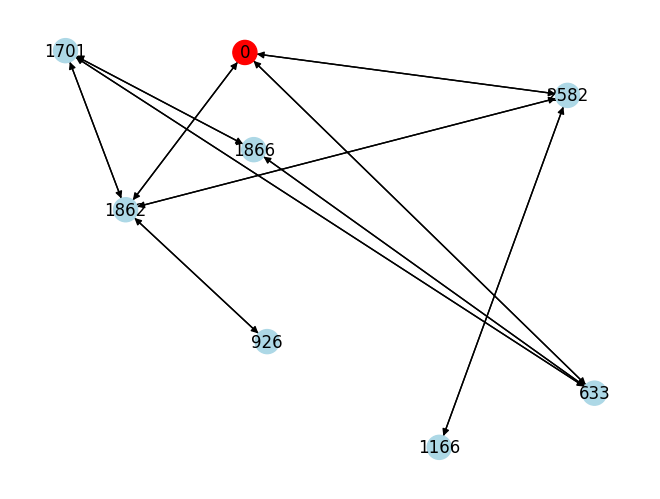

In [59]:
import networkx as nx

labels = {
    id : label[dgl.NID].item()
    for id, label in G.nodes(data=True)
}
node_colors = [
    "red" if label["is_target"].item() == 1 else "lightblue"
    for _, label in G.nodes(data=True)
]
# FIXME: undirected なエッジも取得されてしまう。target nodeに対して向かうエッジだけ取得したい
nx.draw(G, with_labels=True, labels=labels, node_color=node_colors, pos=nx.random_layout(G, seed=1026))